In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import yaml
from os.path import exists

from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import torch
from sklearn import metrics
import pandas as pd

import params

# Load Datasets

In [84]:
# Data of first environement

print("*/!\ Please update the folder strings according to your local environement ! ")

data = np.load("../data/Messung_9/messung9.raw.3_data.npy")
label = np.load("../data/Messung_9/messung9.raw.3_labels.npy")


data10 = np.load("../data/Messung_10/messung10.raw.2_data.npy")
label10 = np.load("../data/Messung_10/messung10.raw.2_labels.npy")



num_classes = max(label[:, 0]) + 1
num_positions = max(label[:, 1]) + 1
print(num_classes, num_positions)

*/!\ Please update the folder strings according to your local environement ! 
13 50


In [85]:
def read_global_log_file(metric_file):
    df = pd.read_csv(metric_file, skiprows=1, index_col=False)
    df.columns = ["metric", "value", "epoch"]
    return df

# Loading Pre-trained Model

In [19]:
pre_trained_model = "ViT_scenario2"


directory = "../data/pre-trained-models/" + pre_trained_model
params.__use_config__(directory + '/config.yaml')

# Load metrics from the run
metrics_file = directory + "/log_metrics.csv"
metric_frame = read_global_log_file(metrics_file)
print(metric_frame["metric"].unique())

# Select a epoch from which to load model from 
choice_metric = "F1 score on test data" #
only_metric_frame = metric_frame[metric_frame["metric"]==choice_metric]
kept_epoch = only_metric_frame.loc[only_metric_frame["value"].idxmax()]["epoch"]
print("Epoch of Maximum:", choice_metric, kept_epoch)
print("Maximum:",choice_metric, only_metric_frame.loc[only_metric_frame["value"].idxmax()]["value"])

model = torch.load(directory +"/model.pth")

['Dev class loss' 'Dev class accuracy' 'Encoder loss' 'learning rate'
 'Positive clustering at error rate 0.1%'
 'Positive clustering at error rate 1%'
 'Positive clustering at error rate 10%' 'Trapz'
 'NN classification on test data' 'max_Trapz' 'NN test2train'
 'NN test2train 10th mean' 'Kmeans cluster score %'
 'Accuracy for dev classification on test data %' 'F1 score on test data'
 'epoch']
Epoch of Maximum: F1 score on test data 23
Maximum: F1 score on test data 0.6567102459280835


In [20]:
from data import MyDataset, MyDataLoader

# Proportion of all data used here
params.data_test_rate = 0.1

def encode_data(mymodel, this_data, this_labels, do_all_data=False):

    z = list(zip(this_data, this_labels))
    loader = MyDataLoader(MyDataset(z))

    mymodel.eval()
    encs, labs = [], []
    count = 0
    amt2encode = len(loader.dataset) * params.data_test_rate
    for i, (batchX, batchY) in enumerate(loader):
        # Compute encoded version of the data by our embedding model
        encs = encs + mymodel.encode(batchX).tolist()
        # Gather device labels accordingly (eventually randomly enumerated)
        labs = labs + batchY.tolist()
        count += batchX.shape[0]
        if not do_all_data and count > amt2encode:
            break
    return encs, labs

# Encoding data with chosen model

In [21]:
encoded_data, encoded_labels = encode_data(model, data, label)
encoded_data10, encoded_labels10 = encode_data(model, data10, label10)

encoded_data10 = np.array(encoded_data10)
encoded_labels10 = np.array(encoded_labels10)

# Random projection
# encoded_data = np.random.rand(50000, 350)
# random_dev_label = np.expand_dims(np.random.choice(13, size=50000), axis=1)
# random_pos_label = np.expand_dims(np.random.choice(50, size=50000), axis=1)
# encoded_labels = np.concatenate((random_dev_label, random_pos_label), axis=1)

# encoded_data10 = np.random.rand(50000, 350)
# random_dev_label = np.expand_dims(np.random.choice(13, size=50000), axis=1)
# random_pos_label = np.expand_dims(np.random.choice(50, size=50000), axis=1)
# encoded_labels10 = np.concatenate((random_dev_label, random_pos_label), axis=1)

print("Size of the sub_set of encoded points: ", len(encoded_data))


Size of the sub_set of encoded points:  77152


# Some Visualisation of Data and Models

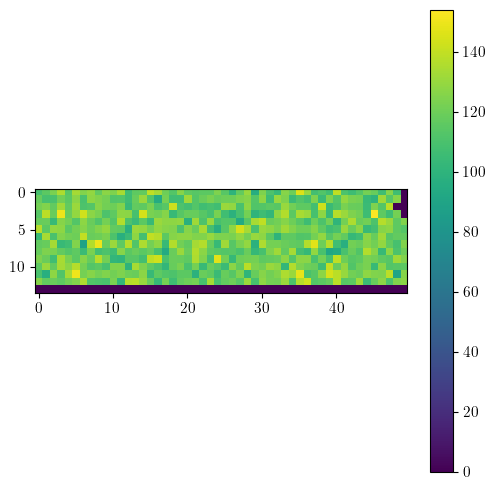

In [86]:
# Visualisation of the amount of data according to Location and Device Id
cleaner_labels = np.array(encoded_labels)

pos_ids = [np.where(cleaner_labels[:,1] == i) for i in range(50)]
dev_ids = [np.where(cleaner_labels[:,0] == i) for i in range(14)]

m = []
for dev in range(14):
    m.append([])
    for pos in range(50):
        ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))
        m[dev].append(len(ids))

m = np.array(m)
plt.imshow(m)
plt.colorbar()
plt.show()

In [23]:
# Plotting
def scatter_plot(X, Y, visible_legend=True):
        dimentions = [[2*i, i*2+1] for i in range(1)]
        colors_base = cm.rainbow(np.linspace(0, 1, num_classes))
        # plt.rcParams["figure.figsize"] = (5,5)
        cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(0, num_classes+1)- 0.5, colors_base)

        print(X.shape)
        print(Y.shape)

        for i in range(len(dimentions)):
                fig, ax = plt.subplots()
                scatter = ax.scatter(X[:, dimentions[i][0]], X[:, dimentions[i][1]], c=Y, norm=norm, cmap=cmap, marker=".", linewidths=0.5, s=25)
                if visible_legend :
                        handles, lab = scatter.legend_elements(prop="colors", num=num_classes, alpha=0.6)
                        legend1 = ax.legend(handles, lab,
                                loc="lower left", title="Device id")
                        ax.add_artist(legend1)
                        ax.set_title("dimentions " + str(i*2) + "and " + str(i*2+1))
                # .legend(loc='upper left',prop = {'size':7},bbox_to_anchor=(1,1))
                # plt.tight_layout(pad=5)
                if not visible_legend:
                        ax.legend().set_visible(False)
                plot_img = "data/plot_"+str(i)+".png"
        return fig

(77152, 192) (77152, 2)
(7715, 192)
(7715,)


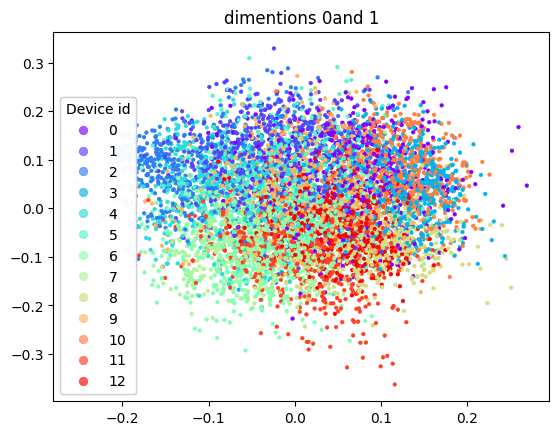

In [24]:
encoded_data = np.array(encoded_data)
encoded_labels = np.array(encoded_labels)

print(encoded_data.shape, encoded_labels.shape)

r = np.random.choice(len(encoded_data), size=len(encoded_data)//10, replace=False)
scatter_plot(np.array(encoded_data)[r], np.array(encoded_labels)[r][:, 0])
plt.show()

# The Evaluations Code

In [30]:
def compute_anchors(this_data, this_labels):
    centroids = []
    for dev in set(this_labels):
        ids_dev = np.where(np.array(this_labels) == dev)[0]
        class_encoded = np.array(this_data)[ids_dev]
        # Should this be a euclidien mean value ??
        centroids.append(class_encoded.mean(axis=0))

    centroids = np.array(centroids)
    print(centroids.shape)

    return centroids

def get_reid_prediction(anchors, this_data, anchor_labels):
    set_labels = list(set(anchor_labels))
    distances_centers = distance_matrix(this_data, anchors)
    predicted_id = np.argmin(distances_centers, axis=1)
    predicted_class = list(map(lambda x: set_labels[x], predicted_id))
    return predicted_class

In [31]:
def re_id_report(anchors_ids, query_ids, query10=False, tight_print=True):

    print("***************")
    print("RE-ID PROTOCOLE")
    print("***************")

    # Compile the re-identification process accuracy
    if query10:
        query_ids = np.random.choice(len(encoded_labels10), len(encoded_labels10)//100, replace=False)
        print(" Perform query with elements from dataset 10: size=", len(query_ids))
        query_labels = encoded_labels10[query_ids][:, 0]
        query_data = encoded_data10[query_ids]
    else :
        query_labels = encoded_labels[query_ids][:, 0]
        query_data = encoded_data[query_ids]

    anchor_labels = encoded_labels[anchors_ids][:, 0]
    anchors = compute_anchors(encoded_data[anchors_ids], anchor_labels)
    print("Number of anchors: ", len(anchors))
    query_predictions = get_reid_prediction(anchors, query_data, anchor_labels)


    if tight_print :
        print("Weighted F1 score for Re-id: ", metrics.f1_score(query_labels, query_predictions, average='weighted'))
    else :
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, query_predictions)
        # print(conf_mx)

        # Confusion Matrix Display
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        # plt.show()

        print('classification_report')
        print(classification_report(query_labels, query_predictions))

In [32]:
def clustering_evaluation(anchors_ids, query_ids, query10=False, tight_print=True, all_data=False):
    if query10:
        query_ids = np.random.choice(len(encoded_labels10), len(encoded_labels10)//50, replace=False)
        print(" Perform query with elements from dataset 10: size=", len(query_ids))
        query_labels = encoded_labels10[query_ids][:, 0]
        query_data = encoded_data10[query_ids]
    else:
        used_ratio = 0.1
        if all_data:
            subset = np.array(list(range(len(encoded_labels[query_ids]))))
        else :
            subset = np.random.choice(len(encoded_labels[query_ids]), int(len(encoded_labels[query_ids])*used_ratio), replace=False)
        print("Metric calculated on ", str(len(subset)), "samples")
        query_labels = encoded_labels[query_ids][:, 0][subset]
        query_data = encoded_data[query_ids][subset]

    mat = distance_matrix(query_data, query_data)
    num_test_dev = max(query_labels)
    
    same_distances = []
    diff_distances = []

    dev_ind = [np.where(np.array(query_labels)==i)[0] for i in range(num_test_dev)]
    for i in range(num_test_dev):
        for j in range(i, num_test_dev):
            sub_mat = mat[dev_ind[i]].T
            subsub_mat = sub_mat[dev_ind[j]]
            for ind_i in range(len(subsub_mat)):
                for ind_j in range(ind_i+1, len(subsub_mat[0])):
                    d = subsub_mat[ind_i][ind_j]
                    if i==j :
                        same_distances.append(d)
                    else :
                        diff_distances.append(d)

    roc_value = []
    th_steps = 50
    min_dist = min(same_distances)
    if len(diff_distances)==0:
        max_dist = min_dist*2
    else :
        max_dist = max(diff_distances)

    for th in range(th_steps+1):
        t = ((th+0.5)/th_steps)
        t = t*t
        threshold = t*max_dist + (1 - t)*min_dist
#         threshold = threshold * threshold
        ta = len(np.where(np.array(same_distances) < threshold)[0])/len(same_distances)
        fa = len(np.where(np.array(diff_distances) < threshold)[0])/len(diff_distances)
        roc_value.append([fa, ta, threshold])
    roc_value = np.array(roc_value) 
    area = np.trapz(roc_value[:, 1], roc_value[:, 0])

    # Get accuracy when fa=0.1% , 1%, 10%
    targets_fa = [0.001, 0.01, 0.1]
    current_target_fa_id = 0
    target_th = []
    ta_accuracy =[]
    for i in range(len(roc_value)):
        if roc_value[i][0] >= targets_fa[current_target_fa_id]:
            target_th.append(roc_value[i][2])
            ta_accuracy.append(roc_value[i][1])
            current_target_fa_id += 1
            if current_target_fa_id >= len(targets_fa):
                break
        
    if tight_print:
        print("> Area size under the clustering curve (Trapz):", area)
    else:
        print("Percentage of each label by value", 100*np.histogram(query_labels, bins=len(set(query_labels)))[0]/len(query_labels))

        print("MaxMin of same:", max(same_distances), min(same_distances))
        print("MaxMin of diff:", max(diff_distances), min(diff_distances))

        print("> Amount of positive clustering when False accuracy reaches 0,1% 1% and 10%")
        print(list(100*np.array(ta_accuracy)), "%")

        print("> Area size under the clustering curve (Trapz)")
        print(area)

In [33]:
def clustering_other_metrics_evaluation(anchors_ids, query_ids, query10=False):
    query_labels = encoded_labels[query_ids][:, 0]
    anchor_labels = encoded_labels[anchors_ids][:, 0]
    querys = encoded_data[query_ids]
    anchors = encoded_data[anchors_ids]

    sil_score = metrics.silhouette_score(querys, query_labels)
    ch_score = metrics.calinski_harabasz_score(querys, query_labels)
    db_score = metrics.davies_bouldin_score(querys, query_labels)

    print("***********************")
    print("SOME CLUSTERING METRICS")
    print("***********************")


    print("Query clustering scores: ", )
    print("Silhouette score in [-1, 1] - ", sil_score)
    print("Calinski Harabasz score [relative] - ", ch_score)
    print("Davies Bouldin score [lower the better] - ", db_score)

In [55]:
def linear_clf_evaluation(anchors_ids, query_ids, tight_print=True, query10=False):
    if query10:
        query_ids = np.random.choice(len(encoded_labels10), len(encoded_labels10)//50, replace=False)
        print(" Perform query with elements from dataset 10: size=", len(query_ids))
        query_labels = encoded_labels10[query_ids][:, 0]
        querys = encoded_data10[query_ids]
    else :
        query_labels = encoded_labels[query_ids][:, 0]
        querys = encoded_data[query_ids]

    anchor_labels = encoded_labels[anchors_ids][:, 0]
    anchors = encoded_data[anchors_ids]


    # Model training
    if False:
        xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

        xgb_model.fit(anchors, anchor_labels)

        predicted_class = xgb_model.predict(querys)
    else :
        from sklearn.linear_model import SGDClassifier
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import make_pipeline
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-3))
        clf.fit(anchors, anchor_labels)
        predicted_class = clf.predict(querys)



    print("********************************")
    print("LINEAR CLASSIFICATION EVALUATION")
    print("********************************")

    if tight_print :
        print("Weighted F1 score for linear separation: ", metrics.f1_score(query_labels, predicted_class, average='weighted'))
    else:
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, predicted_class)
        # print(conf_mx)

        # Confusion Matrix Display
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        plt.show()

        print('classification_report')
        print(classification_report(query_labels, predicted_class))

# Preparing eval data

In [56]:
test_dev = [0, 1, 2] #list(range(13)) #[11, 12]
test_pos = [5, 10, 15]

validation_dev = list(range(13))
validation_pos = [5, 10, 15]

training_dev = [i for i in range(13) if not i in test_dev]
training_pos = [i for i in range(48) if not i in validation_pos]

print(training_pos)

dev_ids = [np.where(encoded_labels[:,0] == i) for i in range(14)]
pos_ids = [np.where(encoded_labels[:,1] == i) for i in range(50)]

[0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


In [57]:
# Separate the indexes from data and label according to the scenarios
train_ids = []
val_ids = []
test_ids = []
scenario2_anchors_ids = []
scenario2_query_ids = []
scenario3_anchors_ids = []
scenario3_query_ids = []
scenario4_anchors_ids = []
for dev in range(len(dev_ids)):
    for pos in range(len(pos_ids)): 
        inter_ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))   
        scenario4_anchors_ids = scenario4_anchors_ids + inter_ids
        # Base separation according to "dev" and "pos" value
        if dev in training_dev and pos in training_pos :
            train_ids = train_ids + inter_ids
            # # Also add distractors to scenario 3
            # scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
        elif dev in validation_dev and pos in validation_pos :
            val_ids = val_ids + inter_ids
            # # Also add distractors to scenario 3
            # scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
        if pos in test_pos :
            test_ids = test_ids + inter_ids
            # Scenario 3 specific
            if pos == test_pos[0] :#and dev in test_dev:  # Select 1 unseen position as the anchor source
                # print("Anchors:", dev, pos)
                scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
            elif dev in test_dev :                  # Other positions are for queries
                # print("Queries:", dev, pos)
                scenario3_query_ids = scenario3_query_ids + inter_ids

        else :
            assert("what is this unclassified data:{:1f}, {:1f}".format(dev, pos))

        # Transversal separation
        if dev in validation_dev and pos in validation_pos :  # Seen devices and 2 unseen positions
            if pos == validation_pos[0]:
                scenario2_anchors_ids = scenario2_anchors_ids + inter_ids
            else :
                scenario2_query_ids = scenario2_query_ids + inter_ids


In [58]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
print(len(scenario2_anchors_ids))
print(len(scenario2_query_ids))
print(len(scenario3_anchors_ids))
print(len(scenario3_query_ids))
print(len(scenario4_anchors_ids))

54021
4745
4745
1642
3103
1642
731
77152


# Scenario 2 With incorporated classifier

In [59]:
params.data_test_rate = 0.2

def encode_prediction_data(mymodel, this_data, this_labels, do_all_data=False):

    z = list(zip(this_data, this_labels))
    loader = MyDataLoader(MyDataset(z))

    mymodel.eval()
    encs, labs = [], []
    count = 0
    amt2encode = len(loader.dataset) * params.data_test_rate
    for i, (batchX, batchY) in enumerate(loader):
        # Compute encoded version of the data by our embedding model
        encs = encs + mymodel(batchX).tolist()
        # Gather device labels accordingly (eventually randomly enumerated)
        labs = labs + batchY.tolist()
        count += batchX.shape[0]
        if not do_all_data and count > amt2encode:
            break
    return encs, labs

In [60]:
preditected_data, true_labels = encode_prediction_data(model, data, label)

In [61]:
preditected_data = np.array(preditected_data)
true_labels = np.array(true_labels)
scenario2direct_query_id = []


dev_ids = [np.where(true_labels[:,0] == i) for i in range(14)]
pos_ids = [np.where(true_labels[:,1] == i) for i in range(50)]
validation_dev = list(range(13))
validation_pos = [5, 10, 15]
for dev in range(len(dev_ids)):
    for pos in range(len(pos_ids)): 
        inter_ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))
        if pos in validation_pos:
            scenario2direct_query_id = scenario2direct_query_id + inter_ids

(154272, 13)
Amount of data on which we perform this evaluation: 9288
Weighted F1 score for linear separation:  0.6467803309243083
confusion matrix


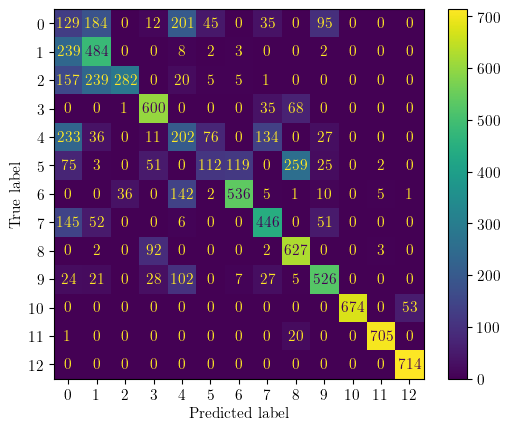

classification_report
              precision    recall  f1-score   support

           0       0.13      0.18      0.15       701
           1       0.47      0.66      0.55       738
           2       0.88      0.40      0.55       709
           3       0.76      0.85      0.80       704
           4       0.30      0.28      0.29       719
           5       0.46      0.17      0.25       646
           6       0.80      0.73      0.76       738
           7       0.65      0.64      0.64       700
           8       0.64      0.86      0.74       726
           9       0.71      0.71      0.71       740
          10       1.00      0.93      0.96       727
          11       0.99      0.97      0.98       726
          12       0.93      1.00      0.96       714

    accuracy                           0.65      9288
   macro avg       0.67      0.64      0.64      9288
weighted avg       0.67      0.65      0.65      9288



In [62]:
import matplotlib as mpl
predicted_class = np.argmax(preditected_data, axis=-1)
print(preditected_data.shape)
print("Amount of data on which we perform this evaluation:", len(scenario2direct_query_id))

print("Weighted F1 score for linear separation: ", metrics.f1_score(true_labels[:, 0][scenario2direct_query_id], predicted_class[scenario2direct_query_id], average='weighted'))
print('confusion matrix')
conf_mx =confusion_matrix(true_labels[:, 0][scenario2direct_query_id], predicted_class[scenario2direct_query_id])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                            display_labels=set(true_labels[:, 0][scenario2direct_query_id]))

# Enable LaTeX formatting
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

disp.plot()
plt.savefig("conf_matrix", dpi=300)
plt.show()
print('classification_report')
print(classification_report(true_labels[:, 0][scenario2direct_query_id], predicted_class[scenario2direct_query_id]))


In [63]:
def voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=1, tight_print=True, same_pos=True):
    
    preditected_data
    
    pos_ids = [np.where(true_labels[:, 1]==i)[0] for i in validation_pos]
    dev_ids = [np.where(true_labels[:, 0]==i)[0] for i in validation_dev]
    all_pos_ids = []
    for pos_i in pos_ids:
        all_pos_ids += list(pos_i)

    real_labels = []
    predicted_class = []
    for d, dev_i in enumerate(dev_ids):
        for p, pos_i in enumerate(pos_ids):
            if len(dev_i)>0 and len(pos_i)>0:
                if same_pos :
                    inter_ids = list(set(dev_i) & set(pos_i))
                else :
                    inter_ids = list(set(dev_i) & set(all_pos_ids))

                # The proba for current ids
                predicted_proba = preditected_data[inter_ids]
                np.random.shuffle(predicted_proba)
                for i in range(len(predicted_proba)//nb_samples):
                    total_proba = np.sum(predicted_proba[i*nb_samples:(i+1)*nb_samples], axis=-2)
                    real_labels.append(d)
                    predicted_class.append(total_proba.argmax())

    print("Multi-sampled vote for:", nb_samples, " samples and same_pos=", same_pos )
    print("Weighted F1 score for linear separation: ", metrics.f1_score(real_labels, predicted_class, average='weighted'))

In [64]:
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=1, tight_print=True, same_pos=True)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=3, tight_print=True, same_pos=True)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=10, tight_print=True, same_pos=True)
print()
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=1, tight_print=True, same_pos=False)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=3, tight_print=True, same_pos=False)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=10, tight_print=True, same_pos=False)


Multi-sampled vote for: 1  samples and same_pos= True
Weighted F1 score for linear separation:  0.6467803309243083
Multi-sampled vote for: 3  samples and same_pos= True
Weighted F1 score for linear separation:  0.6975687164797229
Multi-sampled vote for: 10  samples and same_pos= True
Weighted F1 score for linear separation:  0.7190265331568928

Multi-sampled vote for: 1  samples and same_pos= False
Weighted F1 score for linear separation:  0.6467803309243081
Multi-sampled vote for: 3  samples and same_pos= False
Weighted F1 score for linear separation:  0.7136079287081843
Multi-sampled vote for: 10  samples and same_pos= False
Weighted F1 score for linear separation:  0.7231377502152077


# Scenario 2 aggregated

In [65]:
def voting_linear_clf_evaluation(clf, query_ids, nb_samples=1, tight_print=True, same_pos=True):
    query_labels = encoded_labels[query_ids]
    querys = encoded_data[query_ids]

    pos_ids = [np.where(query_labels[:, 1]==i)[0] for i in range(48)]
    dev_ids = [np.where(query_labels[:, 0]==i)[0] for i in range(13)]
    all_pos_ids = []
    for pos_i in pos_ids:
        all_pos_ids += list(pos_i)

    real_labels = []
    predicted_class = []
    for d, dev_i in enumerate(dev_ids):
        for p, pos_i in enumerate(pos_ids):
            if len(dev_i)>0 and len(pos_i)>0:
                if same_pos :
                    inter_ids = list(set(dev_i) & set(pos_i))
                else :
                        inter_ids = list(set(dev_i) & set(all_pos_ids))

                predicted_proba = clf.predict_proba(querys[inter_ids])
                predicted_proba = np.array(predicted_proba)
                np.random.shuffle(predicted_proba)
                for i in range(len(predicted_proba)//nb_samples):
                    total_proba = np.sum(predicted_proba[i*nb_samples:(i+1)*nb_samples], axis=-2)
                    real_labels.append(d)
                    predicted_class.append(total_proba.argmax())

    print("Multi-sampled vote for:", nb_samples, " samples and same_pos=", same_pos )
    print("Weighted F1 score for linear separation: ", metrics.f1_score(real_labels, predicted_class, average='weighted'))
    if not tight_print:
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, predicted_class)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        plt.show()
        print('classification_report')
        print(classification_report(query_labels, predicted_class))

In [51]:
anchors_ids = scenario2_anchors_ids
query_ids = scenario2_query_ids

anchor_labels = encoded_labels[anchors_ids][:, 0]
anchors = encoded_data[anchors_ids]

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
# clf = make_pipeline(StandardScaler(),
#                     SGDClassifier(max_iter=1000, tol=1e-3))

base_model = SGDClassifier(max_iter=1000, tol=1e-3)
clf = CalibratedClassifierCV(base_model)

clf.fit(anchors, anchor_labels)

voting_linear_clf_evaluation(clf, query_ids, nb_samples=1)
voting_linear_clf_evaluation(clf, query_ids, nb_samples=3)
voting_linear_clf_evaluation(clf, query_ids, nb_samples=10)
# voting_linear_clf_evaluation(clf, query_ids, nb_samples=20)
print()
voting_linear_clf_evaluation(clf, query_ids, nb_samples=1, same_pos=False)
voting_linear_clf_evaluation(clf, query_ids, nb_samples=3, same_pos=False)
voting_linear_clf_evaluation(clf, query_ids, nb_samples=10, same_pos=False)
# voting_linear_clf_evaluation(clf, query_ids, nb_samples=20, same_pos=False)

Multi-sampled vote for: 1  samples and same_pos= True
Weighted F1 score for linear separation:  0.5261706369315616
Multi-sampled vote for: 3  samples and same_pos= True
Weighted F1 score for linear separation:  0.5596821216610575
Multi-sampled vote for: 10  samples and same_pos= True
Weighted F1 score for linear separation:  0.5755541264639009

Multi-sampled vote for: 1  samples and same_pos= False
Weighted F1 score for linear separation:  0.5261706369315616
Multi-sampled vote for: 3  samples and same_pos= False
Weighted F1 score for linear separation:  0.596134628925584
Multi-sampled vote for: 10  samples and same_pos= False
Weighted F1 score for linear separation:  0.6501653362210418


## Scenario 1
Devices and Position from the training set. 

(!) In practice the reported values have been compiled during training on specific datapoints that were excluded from training

In [66]:
np.random.shuffle(train_ids)
anchors_ids = train_ids[:len(train_ids)//2]
query_ids = train_ids[len(train_ids)//2:]

print(len(anchors_ids))
print(len(query_ids))

re_id_report(anchors_ids, query_ids)
clustering_evaluation(anchors_ids, query_ids)
linear_clf_evaluation(anchors_ids, query_ids)

27010
27011
***************
RE-ID PROTOCOLE
***************
(10, 192)
Number of anchors:  10
Weighted F1 score for Re-id:  0.9454867693998528
Metric calculated on  2701 samples
> Area size under the clustering curve (Trapz): 0.9240529911518359
********************************
LINEAR CLASSIFICATION EVALUATION
********************************
Weighted F1 score for linear separation:  0.9729620822683429


## Scenario 2
All train devices in unknown position

11 Devices in 2 positions

In [67]:
anchors_ids = scenario2_anchors_ids
query_ids = scenario2_query_ids

re_id_report(anchors_ids, query_ids, tight_print=True)
clustering_evaluation(anchors_ids, query_ids)
linear_clf_evaluation(anchors_ids, query_ids)

***************
RE-ID PROTOCOLE
***************
(13, 192)
Number of anchors:  13
Weighted F1 score for Re-id:  0.5670275196132892
Metric calculated on  310 samples
> Area size under the clustering curve (Trapz): 0.931700212994695
********************************
LINEAR CLASSIFICATION EVALUATION
********************************
Weighted F1 score for linear separation:  0.5340674331655544


## Scenario 3
Devices and position unknown

In [68]:
anchors_ids = scenario3_anchors_ids
query_ids = scenario3_query_ids

print("Number of query_ids:", len(query_ids))
re_id_report(anchors_ids, query_ids, tight_print=True)
clustering_evaluation(anchors_ids, query_ids, all_data=True)
linear_clf_evaluation(anchors_ids, query_ids)


Number of query_ids: 731
***************
RE-ID PROTOCOLE
***************
(13, 192)
Number of anchors:  13
Weighted F1 score for Re-id:  0.45275467536369807
Metric calculated on  731 samples
> Area size under the clustering curve (Trapz): 0.6530289408312642
********************************
LINEAR CLASSIFICATION EVALUATION
********************************
Weighted F1 score for linear separation:  0.43945366378330336


# Scenario 4

Evaluation on complietely different environement.

In [69]:
anchors_ids = train_ids
# query_ids = 

re_id_report(anchors_ids, query_ids, query10=True)
clustering_evaluation(anchors_ids, query_ids, query10=True)
xgboost_evaluation(anchors_ids, query_ids, query10=True)

***************
RE-ID PROTOCOLE
***************
 Perform query with elements from dataset 10: size= 777
(10, 192)
Number of anchors:  10
Weighted F1 score for Re-id:  0.12162121933832062
 Perform query with elements from dataset 10: size= 1555
> Area size under the clustering curve (Trapz): 0.6367605152410407
 Perform query with elements from dataset 10: size= 1555
*****************************
XGB CLASSIFICATION EVALUATION
*****************************
Weighted F1 score for linear separation:  0.1433949084604295


# Other visualisations

In [70]:
# For each class, gather the centroid from train data as an anchor
centroids = []

for dev in range(num_classes):
    ids_dev = np.where(np.array(encoded_labels) == dev)[0]
    class_encoded = np.array(encoded_data)[ids_dev]    
    centroids.append(class_encoded.mean(axis=0))

centroids = np.array(centroids)
print(centroids.shape)


(13, 192)


(77152, 192)
(77152, 13)
[1.05213776 1.05937763 1.11617751 1.1172372  1.07330042 1.05422948
 1.08372564 1.14572172 1.09669835 1.07504057 1.11900994 1.11496854
 1.1340638 ]


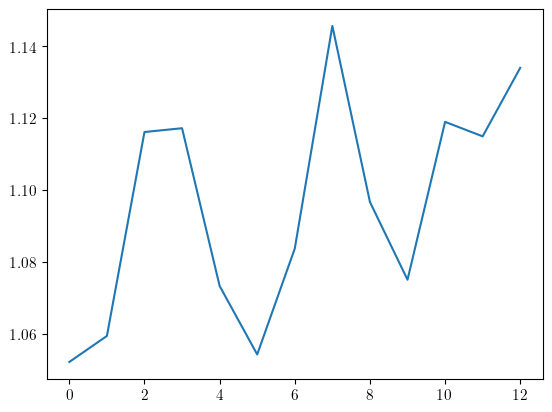

In [71]:
print(encoded_data.shape)
distances_centers = distance_matrix(encoded_data, centroids)
print(distances_centers.shape)
avg_ditance2center = np.mean(distances_centers, axis=0)
print(avg_ditance2center)
plt.plot(avg_ditance2center)
plt.show()

In [72]:
predicted_class = np.argmin(distances_centers, axis=1)
print(max(predicted_class))
print(max(encoded_labels[:, 0]))
print(predicted_class.shape)

12
12
(77152,)


confusion matrix
[[4722  278    1  152  204   66   43  108   38  106    1    3  112]
 [ 192 5332   16   20   84   37    4   11    9   34    6    1    0]
 [ 257  209 4857   73   90    0   26   92   19   12    4   44    0]
 [   6   12   11 5675    2   11    5   30  114   22   13    9    5]
 [ 128  148   11    3 4955   89   73  365    1  173    0    1    0]
 [  75   81    0   51   29 5342  164    1  201   19    2   90   13]
 [   5    4   36   14  103  296 5299   38   48   57    1  109    0]
 [  92   20    0    0   46    2   10 5835    6   76    0    0    0]
 [  19   25    9  441    2   46   35   20 5074    4    9  116    0]
 [ 124  104   40   24  282   70   41  317    2 4986    6   20    0]
 [   0    0    0   18    0   21    1    0   11    0 5748   33  147]
 [   0   17   21   45    0   44   10    0   18    0   55 5751   82]
 [   0    0    1    0    0    0    0    0    0    0    2    2 6019]]


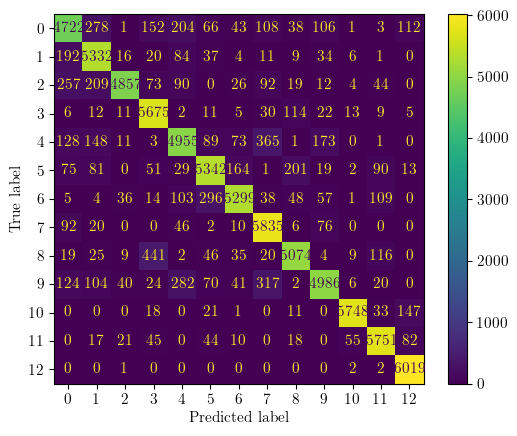

classification_report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      5834
           1       0.86      0.93      0.89      5746
           2       0.97      0.85      0.91      5683
           3       0.87      0.96      0.91      5915
           4       0.85      0.83      0.84      5947
           5       0.89      0.88      0.88      6068
           6       0.93      0.88      0.90      6010
           7       0.86      0.96      0.90      6087
           8       0.92      0.87      0.89      5800
           9       0.91      0.83      0.87      6016
          10       0.98      0.96      0.97      5979
          11       0.93      0.95      0.94      6043
          12       0.94      1.00      0.97      6024

    accuracy                           0.90     77152
   macro avg       0.90      0.90      0.90     77152
weighted avg       0.90      0.90      0.90     77152

predicted clusters
(77152, 192)
(77152,)


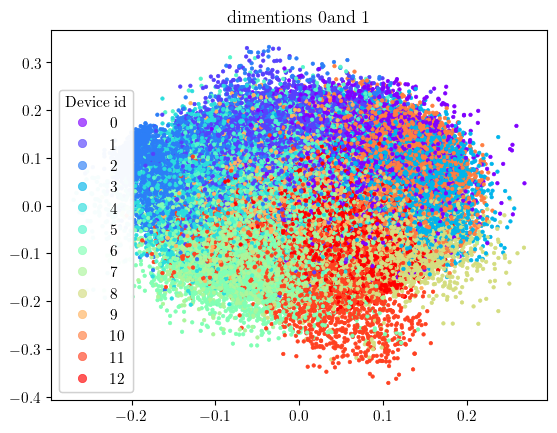

Ground truth labels
(77152, 192)
(77152,)


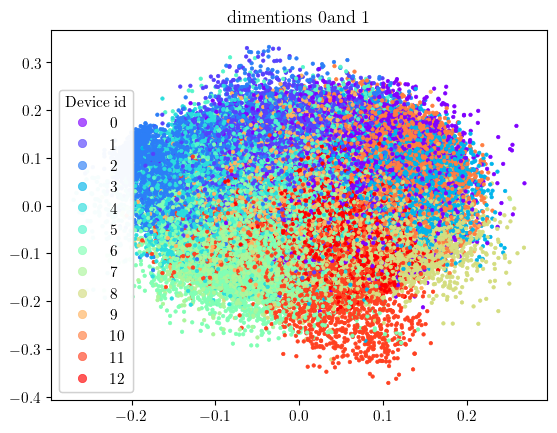

In [73]:
print('confusion matrix')
conf_mx =confusion_matrix(encoded_labels[:, 0], predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(encoded_labels[:, 0], predicted_class))


print("predicted clusters")
scatter_plot(np.array(encoded_data), np.array(predicted_class))
plt.show()

print("Ground truth labels")
scatter_plot(np.array(encoded_data), np.array(encoded_labels[:, 0]))
plt.show()

13 50
(10000, 2)
(10000,)


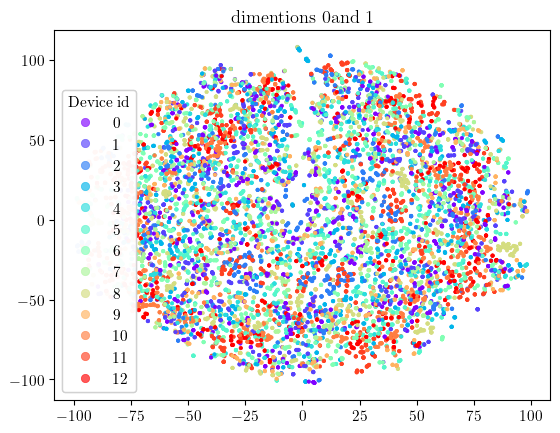

In [74]:
# T-SNE from the raw data
data = np.load("../data/Messung_9/messung9.raw.3_data.npy")
label = np.load("../data/Messung_9/messung9.raw.3_labels.npy")

num_classes = max(label[:, 0]) + 1
num_positions = max(label[:, 1]) + 1
print(num_classes, num_positions)


subset = np.random.choice(len(data), 10000)
magnitude_data = list(map(lambda x: np.abs(x), np.array(data)[subset]))
T_SNE_raw = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(magnitude_data))
scatter_plot(T_SNE_raw, label[subset, 0])
plt.show()


In [75]:
# Check miss classification in 2D
sub_encoded_data, sub_encoded_labels = encode_data(model, data[subset], label[subset])
T_SNE_sub_encoded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(sub_encoded_data))

In [76]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2016, 2)
(2016,)


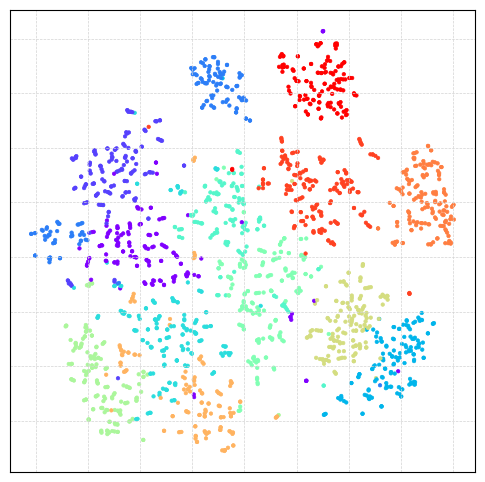

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 2)
(10000,)


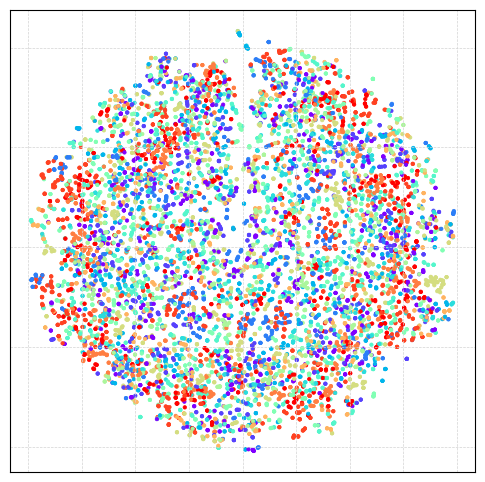

In [77]:
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.stats import sem
import tikzplotlib

mpl.rcParams['text.usetex'] = True
mpl.rc('font', family='Times New Roman', size=11)
cols = "tab10"

plt.rcParams["figure.figsize"] = (6, 6)

scatter_plot(T_SNE_sub_encoded, np.array(sub_encoded_labels)[:, 0], visible_legend=False)
plt.gca().set_title("")
# plt.gca().axis('off')
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
# plt.gca().legend().set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

plt.savefig('scatter-tsne-structured.png')
plt.show()

scatter_plot(T_SNE_raw, label[subset, 0], visible_legend=False)

plt.gca().set_title("")
# plt.gca().axis('off')
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
# plt.gca().legend().set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

plt.savefig('scatter-tsne-raw.png')
plt.show()
